# Анализ лояльности пользователей Яндекс Афиши

- Автор: Киян Антон
- Дата: 25.10.2025

### Цели и задачи проекта

Исследовательский анализ данных, чтобы выяснить, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. 

### Этапы выполнения проекта

#### 1. Загрузка данных из БД и их предобработка
#### 2. Предобработка данных
#### 3. Создание профиля пользователя
####  4. Исследовательский анализ данных
##### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу
##### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа
##### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки
##### 4.4. Корреляционный анализ количества покупок и признаков пользователя
#### 5. Общий вывод и рекомендации

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install sqlalchemy
!pip install psycopg2-binary
!pip install phik
!pip install dotenv
import os
import dotenv
import pandas as pd
from sqlalchemy import create_engine

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

In [2]:
load_dotenv() # автоматически ищет .env в текущей директории

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
)

engine = create_engine(connection_string)

In [3]:
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT user_id,
       device_type_canonical,
       order_id,
       created_dt_msk as order_dt,
       created_ts_msk as order_ts,
       currency_code,
       revenue,
       tickets_count,
       days_since_prev,
       event_id,
       service_name,
       event_type_main,
       region_name,
       city_name
FROM(
SELECT user_id,
       device_type_canonical,
       order_id,
       created_dt_msk,
       created_ts_msk,
       currency_code,
       revenue,
       tickets_count,
       event_id,
       event_name_code,
       service_name,
       event_type_main,
       region_name,
       city_name,
       LAG(created_dt_msk,1) OVER (PARTITION BY user_id ORDER BY created_dt_msk) as drt,
       created_dt_msk::date - LAG(created_dt_msk::date) OVER (PARTITION BY user_id ORDER BY created_dt_msk) as days_since_prev
FROM afisha.purchases
LEFT JOIN afisha.events USING (event_id)
LEFT JOIN afisha.city USING (city_id)
LEFT JOIN afisha.regions USING (region_id)
WHERE (device_type_canonical = 'mobile' or device_type_canonical = 'desktop') AND event_type_main != 'фильм'
ORDER BY user_id) as ttt
'''
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

In [5]:
display(df.head())

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


**Промежуточный вывод 1.2**

Всего в данных 14 столбцов и 290 611 строк. Пропуски есть только в столбце `days_since_prev` - это связано с тем, что не все пользователи совершали повторные покупки и для первой покупки значение отсутствует.

**Формат данных**

1) `order_dt` - представлен datetime64[ns]. Можно скорректировать `order_dt` - до дней

2) `order_id` и `event_id` - это идентификаторы и числовых операций не будет, поэтому исправление на формат 'object'

3) размерность всех int64 и float64 уменьшить

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Выгрузка данных, изменение формата в дату для дальнейшего присоедения

In [6]:
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [7]:
tenge_df['data']=pd.to_datetime(tenge_df['data'])
print(tenge_df.info())
print(tenge_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB
None
        data  nominal     curs  cdx
0 2024-01-10      100  19.9391  kzt
1 2024-01-11      100  19.7255  kzt
2 2024-01-12      100  19.5839  kzt
3 2024-01-13      100  19.4501  kzt
4 2024-01-14      100  19.4501  kzt


Присоединение датафреймов с входной и выходной проверкой количества данных

In [8]:
temp = df.copy() 
len(temp)

290611

In [9]:
df_df = pd.merge(df, tenge_df, left_on='order_dt',right_on='data', how='left')

In [10]:
temp = df_df.copy() 
len(temp)

290611

Перевод валюты по отношению к дате совершения сделки

In [11]:
df_df['revenue_rub'] = df_df.apply(lambda row: row['revenue'] if row['currency_code'] == 'rub' else row['revenue']/100*row['curs'], axis=1)

Удаление лишних столбцов и проверка

In [12]:
df = df_df.drop(['data', 'nominal', 'curs', 'cdx'], axis=1)

In [13]:
print(df[df['currency_code'] != 'rub'].head())

             user_id device_type_canonical  order_id   order_dt  \
70   0033403583a55ed                mobile   7850214 2024-09-17   
89   0040e12d70fae81               desktop   8634925 2024-09-02   
96   0054b38b2653e6e                mobile   7625522 2024-09-09   
277  00f4f5244501ce6                mobile    720419 2024-06-11   
460  01370a0e9c1a7d5                mobile   2229811 2024-06-04   

               order_ts currency_code   revenue  tickets_count  \
70  2024-09-17 16:52:06           kzt    518.10              4   
89  2024-09-02 19:49:14           kzt    347.18              3   
96  2024-09-09 18:06:04           kzt    328.77              4   
277 2024-06-11 20:15:57           kzt  22021.55              5   
460 2024-06-04 13:19:47           kzt   7397.66              4   

     days_since_prev  event_id        service_name event_type_main  \
70              20.0    559919  Билеты без проблем          другое   
89              39.0    559476  Билеты без проблем          

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [14]:
df.duplicated().sum()

0

In [15]:
df.duplicated(subset='order_id').sum()

0

In [16]:
df.duplicated(subset=['user_id','device_type_canonical','currency_code','revenue','tickets_count','event_id','service_name','event_type_main','region_name','city_name','revenue_rub']).sum()

64405

In [17]:
df[df.duplicated(subset=['user_id','device_type_canonical','currency_code','revenue','tickets_count','event_id','service_name','event_type_main','region_name','city_name','revenue_rub'], keep='first')]

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
12,000cf0659a9f40f,mobile,6818104,2024-06-20,2024-06-20 12:46:11,rub,710.95,2,0.0,516728,Лови билет!,концерты,Широковская область,Радужнополье,710.95
13,000cf0659a9f40f,mobile,6818075,2024-06-20,2024-06-20 12:42:12,rub,1421.91,4,0.0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1421.91
14,000cf0659a9f40f,mobile,6818046,2024-06-20,2024-06-20 12:40:27,rub,1421.91,4,0.0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1421.91
15,000cf0659a9f40f,mobile,6818220,2024-06-20,2024-06-20 10:56:16,rub,1421.91,4,0.0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1421.91
16,000cf0659a9f40f,mobile,6818017,2024-06-20,2024-06-20 10:35:26,rub,1421.91,4,0.0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1421.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290581,fffcd3dde79eb2c,mobile,3260036,2024-08-04,2024-08-04 11:16:39,rub,213.81,3,0.0,554265,Лучшие билеты,спорт,Каменевский регион,Глиногорск,213.81
290582,fffcd3dde79eb2c,mobile,3260065,2024-08-04,2024-08-04 11:14:13,rub,213.81,3,0.0,554265,Лучшие билеты,спорт,Каменевский регион,Глиногорск,213.81
290586,fffcd3dde79eb2c,mobile,8064727,2024-08-21,2024-08-21 21:30:50,rub,814.51,3,0.0,516365,Лови билет!,концерты,Яблоневская область,Светополье,814.51
290587,fffcd3dde79eb2c,mobile,8064814,2024-08-21,2024-08-21 21:40:02,rub,814.51,3,0.0,516365,Лови билет!,концерты,Яблоневская область,Светополье,814.51


In [18]:
df=df.drop_duplicates(subset=['user_id','device_type_canonical','currency_code','revenue','tickets_count','event_id','service_name','event_type_main','region_name','city_name','revenue_rub']).copy()

In [19]:
temp = df.copy() 
len(temp)

226206

Проверка пропусков

In [20]:
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [21]:
df.isna().sum() / df.shape[0]

user_id                  0.00000
device_type_canonical    0.00000
order_id                 0.00000
order_dt                 0.00000
order_ts                 0.00000
currency_code            0.00000
revenue                  0.00000
tickets_count            0.00000
days_since_prev          0.09696
event_id                 0.00000
service_name             0.00000
event_type_main          0.00000
region_name              0.00000
city_name                0.00000
revenue_rub              0.00000
dtype: float64

Корректировка типов данных (наносекунды я пытался сократить, данные превращались в object, поэтому переделывать не стал)

In [22]:
df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
service_name                     object
event_type_main                  object
region_name                      object
city_name                        object
revenue_rub                     float64
dtype: object

In [23]:
for column in ['tickets_count']:
    df[column] = pd.to_numeric(df[column], downcast='integer')

for column in ['revenue','revenue_rub','days_since_prev']:
    df[column] = pd.to_numeric(df[column], downcast='float')
    
df['order_id'] = df['order_id'].astype(object)
df['event_id'] = df['event_id'].astype(object)

In [24]:
df.dtypes

user_id                          object
device_type_canonical            object
order_id                         object
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float32
tickets_count                      int8
days_since_prev                 float32
event_id                         object
service_name                     object
event_type_main                  object
region_name                      object
city_name                        object
revenue_rub                     float32
dtype: object

Вывод уникальных значений в категориях

In [25]:
df['device_type_canonical'].unique()

array(['mobile', 'desktop'], dtype=object)

In [26]:
df['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

In [27]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

Вывод статистических значений и отчистка от выбросов

In [28]:
df['revenue_rub'].describe()

count    226206.000000
mean        566.934204
std         893.116150
min         -90.760002
25%         126.190002
50%         369.820007
75%         812.140015
max       81174.539062
Name: revenue_rub, dtype: float64

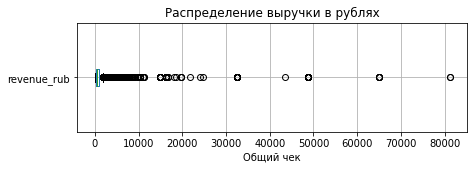

In [29]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 2))

# Строим диаграмму размаха значений в столбце score
df.boxplot(column='revenue_rub', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение выручки в рублях')
plt.xlabel('Общий чек')

# Выводим график
plt.show()

In [30]:
revenue_rub_99=df['revenue_rub'].quantile(0.99)
print(revenue_rub_99)

2607.162109375


In [31]:
df['tickets_count'].describe()

count    226206.000000
mean          2.761501
std           1.181264
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

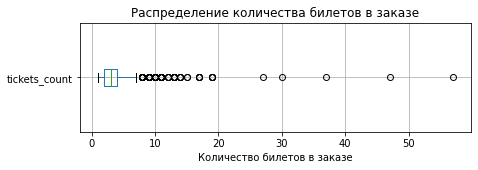

In [32]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 2))

# Строим диаграмму размаха значений в столбце score
df.boxplot(column='tickets_count', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов в заказе')

# Выводим график
plt.show()

In [33]:
tickets_count_99=df['tickets_count'].quantile(0.99)
print(tickets_count_99)

6.0


In [34]:
df.loc[df['revenue_rub'] <0].count()

user_id                  320
device_type_canonical    320
order_id                 320
order_dt                 320
order_ts                 320
currency_code            320
revenue                  320
tickets_count            320
days_since_prev          284
event_id                 320
service_name             320
event_type_main          320
region_name              320
city_name                320
revenue_rub              320
dtype: int64

In [35]:
new_df = df.loc[(df['revenue_rub'] <= revenue_rub_99) & (df['revenue_rub'] > 0) & (df['tickets_count'] <= tickets_count_99)]

In [36]:
new_df['revenue_rub'].describe()

count    219895.000000
mean        537.278625
std         507.506500
min           0.020000
25%         134.129997
50%         374.410004
75%         805.345001
max        2607.162109
Name: revenue_rub, dtype: float64

In [37]:
new_df['tickets_count'].describe()

count    219895.000000
mean          2.745433
std           1.145030
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: tickets_count, dtype: float64

In [38]:
temp2 = new_df.copy() 
len(temp2)

219895

In [39]:
poterya=len(temp)-len(temp2)
skolko=poterya/len(temp)
print(poterya,skolko)

6311 0.02789934838156371


In [40]:
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219895 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                219895 non-null  object        
 1   device_type_canonical  219895 non-null  object        
 2   order_id               219895 non-null  object        
 3   order_dt               219895 non-null  datetime64[ns]
 4   order_ts               219895 non-null  datetime64[ns]
 5   currency_code          219895 non-null  object        
 6   revenue                219895 non-null  float32       
 7   tickets_count          219895 non-null  int8          
 8   days_since_prev        198547 non-null  float32       
 9   event_id               219895 non-null  object        
 10  service_name           219895 non-null  object        
 11  event_type_main        219895 non-null  object        
 12  region_name            219895 non-null  obje

**Вывод предобработки данных.**

Были пробразованы типы данных столбцов:
`order_dt`, `event_id` - в object
`revenue`, `tickets_count`, `days_since_prev` - уменьшена размерность

`revenue_rub` - добавлен столбец с выручкой в рублях (тенге переведены по курсу на день совершения сделки)

`revenue_rub`, `tickets_count` - проверены статистические данные, произошла фильтрация по 99 процентилю из-за сильных выбросов влияющих на общую статистику
Эти данные составили 1% от общего числа строк.

Данные сохранены в `new_df` 

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [41]:
new_df = new_df.sort_values(by='order_dt', ascending=False).copy()
value_counts = new_df['user_id'].value_counts()
print(value_counts)

0beb8fc0c0a9ce1    7130
18e9aead0a393e7    3097
8187dac4be757a0    2815
3ee7dc2e115847f    2772
1c2a2133e1df1b4    2565
                   ... 
25287c1e5ce204a       1
ecc0b3dd4cb8b04       1
ae453c840126764       1
c92c958acb3e120       1
7ec0c5fa40186ea       1
Name: user_id, Length: 21679, dtype: int64


In [42]:
predfinal_df = new_df.groupby('user_id').agg(
    first_order=('order_ts', 'min'),
    last_order=('order_ts', 'max'),
    device_type_canonical=('device_type_canonical','first'),
    region_name=('region_name','first'),
    service_name=('service_name','first'),
    event_type_main=('event_type_main','first'),
    order_count=('order_id', 'count'),
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days=('days_since_prev', 'mean')
).reset_index()

In [43]:
#temp = grouped_df.copy() 
#len(temp)

In [44]:
#new_df2 = pd.merge(grouped_df, new_df, left_on=['user_id', 'first_order'], right_on=['user_id', 'order_ts'], how='left')

In [45]:
#temp = new_df2.copy() 
#len(temp)

In [46]:
#predfinal_df = new_df2[['user_id', 'first_order', 'last_order', 'device_type_canonical', 'region_name', 'service_name', 'event_type_main', 'order_count', 'avg_revenue', 'avg_tickets','avg_days']].copy()

In [47]:
y=0
def create_is_y(x):
    if x>y:
        return 1
    return 0

In [48]:
y=1
predfinal_df['is_two'] = predfinal_df['order_count'].apply(create_is_y)

In [49]:
y=4
predfinal_df['is_five'] = predfinal_df['order_count'].apply(create_is_y)

In [50]:
display(predfinal_df.head())

,user_id,first_order,last_order,device_type_canonical,region_name,service_name,event_type_main,order_count,avg_revenue,avg_tickets,avg_days,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,За билетом!,другое,2,774.010010,3.000000,75.0,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Лугоградская область,Облачко,концерты,3,767.213318,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,Лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [51]:
value_counts = predfinal_df['user_id'].value_counts()
print(f'общее число пользователей в выборке: {value_counts.count()}')

общее число пользователей в выборке: 21679


In [52]:
value_mean = predfinal_df['avg_revenue'].mean()
print(f'средняя выручка с одного заказа: {round(value_mean,2)}')

средняя выручка с одного заказа: 549.489990234375


In [53]:
is_two_mean = predfinal_df['is_two'].mean()
print(f'доля пользователей, совершивших 2 и более заказа: {round(is_two_mean,2)}')

доля пользователей, совершивших 2 и более заказа: 0.59


In [54]:
is_five_mean = predfinal_df['is_five'].mean()
print(f'доля пользователей, совершивших 5 и более заказов: {round(is_five_mean,2)}')

доля пользователей, совершивших 5 и более заказов: 0.24


In [55]:
temp_predfinal = predfinal_df.copy() 
len(temp_predfinal)

21679

In [56]:
predfinal_df[['order_count','avg_days','avg_tickets','avg_revenue']].describe()

,order_count,avg_days,avg_tickets,avg_revenue
count,21679.000000,12857.000000,21679.000000,21679.000000
mean,10.143226,18.454838,2.741939,549.491516
std,87.990538,23.529388,0.897708,423.621796
min,1.000000,0.000000,1.000000,0.070000
25%,1.000000,2.220588,2.000000,222.474556
50%,2.000000,10.600000,2.750000,480.954010
75%,4.000000,24.666666,3.000000,763.943726
max,7130.000000,148.000000,6.000000,2607.162109


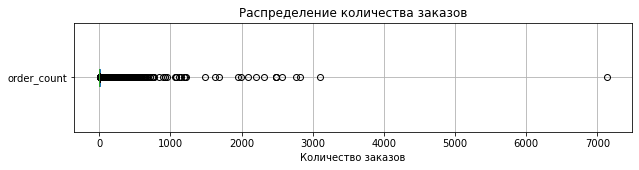

In [57]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 2))

# Строим диаграмму размаха значений в столбце score
predfinal_df.boxplot(column='order_count', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение количества заказов')
plt.xlabel('Количество заказов')

# Выводим график
plt.show()

In [58]:
count_95=predfinal_df['order_count'].quantile(0.95)
print(count_95)

24.0


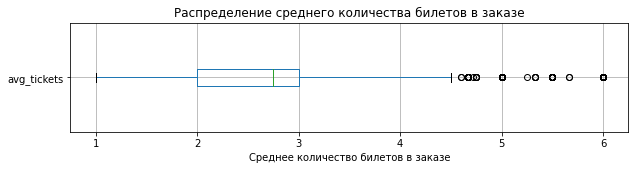

In [59]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 2))

# Строим диаграмму размаха значений в столбце score
predfinal_df.boxplot(column='avg_tickets', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение среднего количества билетов в заказе')
plt.xlabel('Среднее количество билетов в заказе')

# Выводим график
plt.show()

In [60]:
tickets_99=predfinal_df['avg_tickets'].quantile(0.99)
print(tickets_99)

5.0


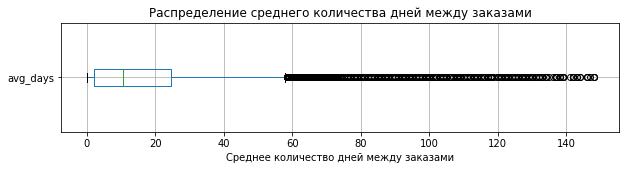

In [61]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 2))

# Строим диаграмму размаха значений в столбце score
predfinal_df.boxplot(column='avg_days', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение среднего количества дней между заказами')
plt.xlabel('Среднее количество дней между заказами')

# Выводим график
plt.show()

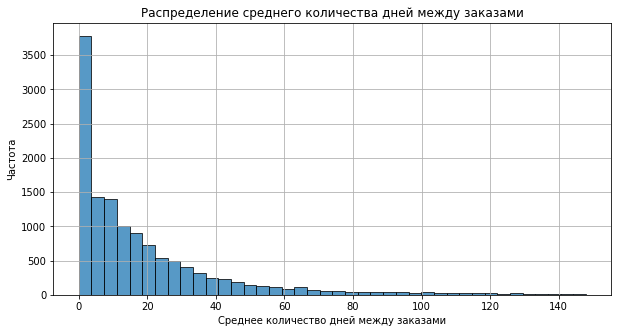

In [62]:
plt.figure(figsize=(10, 5))

predfinal_df['avg_days'].plot(
                kind='hist',
                bins=40,
                alpha=0.75,
                edgecolor='black',
                rot=0,
    
)

# Настраиваем оформление графика
plt.title('Распределение среднего количества дней между заказами')
plt.xlabel('Среднее количество дней между заказами')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [63]:
days_99=predfinal_df['avg_days'].quantile(0.99)
print(days_99)

116.44


Данных достаточно по объёму

В среднем количестве билетов в заказе аномалий не обнаружено, в среднем количестве дней между заказами может показаться, что в данных также есть аномалии, но распределение похоже на нормальное.

В количестве заказов обнаружено анамально большие значения. Принято решение отфильтровать по 95-му перцентилю. 

In [64]:
final_df = predfinal_df.loc[predfinal_df['order_count'] < count_95]

In [65]:
temp_final = final_df.copy() 
len(temp_final)

20567

In [66]:
(len(temp_predfinal)-len(temp_final))/len(temp_predfinal)

0.05129387886895152

Итоговый набор данных был сокращен на 5%, что составляет 20594 значений.

In [67]:
final_df[['order_count','avg_days','avg_tickets','avg_revenue']].describe()

,order_count,avg_days,avg_tickets,avg_revenue
count,20567.000000,11745.000000,20567.000000,20567.000000
mean,3.290903,19.925608,2.742316,550.266052
std,3.814327,24.099144,0.920194,433.801239
min,1.000000,0.000000,1.000000,0.070000
25%,1.000000,3.000000,2.000000,211.625000
50%,2.000000,12.500000,2.750000,468.479980
75%,4.000000,27.000000,3.111111,780.936920
max,23.000000,148.000000,6.000000,2607.162109


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [68]:
colich_event_type_main=final_df['event_type_main'].value_counts()
print(f'Распределение количества по типам мероприятий:\n{colich_event_type_main}')
dolya_event_type_main=final_df['event_type_main'].value_counts()/len(final_df)
print(f'Доля по типам мероприятий:\n{dolya_event_type_main}')

Распределение количества по типам мероприятий:
концерты    8797
другое      4801
театр       4379
стендап     1013
спорт        966
выставки     418
ёлки         193
Name: event_type_main, dtype: int64
Доля по типам мероприятий:
концерты    0.427724
другое      0.233432
театр       0.212914
стендап     0.049254
спорт       0.046968
выставки    0.020324
ёлки        0.009384
Name: event_type_main, dtype: float64


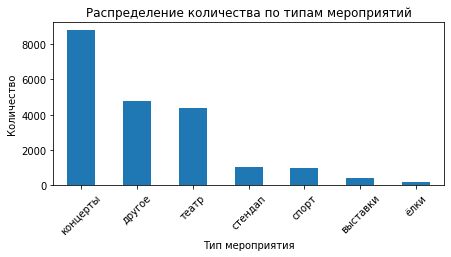

In [69]:
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
colich_event_type_main.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=45, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение количества по типам мероприятий'
)

# Настраиваем оформление графика
plt.xlabel('Тип мероприятия')
plt.ylabel('Количество')

# Выводим график
plt.show()

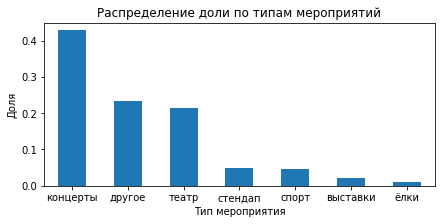

In [70]:
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
dolya_event_type_main.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли по типам мероприятий'
)

# Настраиваем оформление графика
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля')

# Выводим график
plt.show()

In [71]:
colich_device_type_canonical=final_df['device_type_canonical'].value_counts()
print(f'Распределение количества по типам устройств:\n{colich_device_type_canonical}')
dolya_device_type_canonical=final_df['device_type_canonical'].value_counts()/len(final_df)
print(f'Доля по типам устройств:\n{dolya_device_type_canonical}')

Распределение количества по типам устройств:
mobile     17086
desktop     3481
Name: device_type_canonical, dtype: int64
Доля по типам устройств:
mobile     0.830748
desktop    0.169252
Name: device_type_canonical, dtype: float64


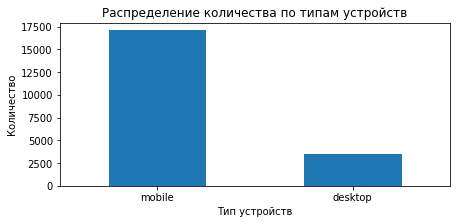

In [72]:
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
colich_device_type_canonical.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение количества по типам устройств'
)

# Настраиваем оформление графика
plt.xlabel('Тип устройств')
plt.ylabel('Количество')

# Выводим график
plt.show()

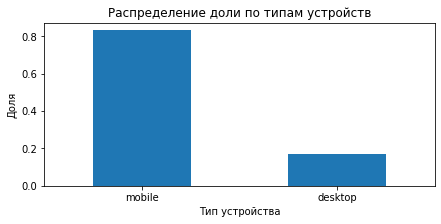

In [73]:
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
dolya_device_type_canonical.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли по типам устройств'
)

# Настраиваем оформление графика
plt.xlabel('Тип устройства')
plt.ylabel('Доля')

# Выводим график
plt.show()

In [74]:
colich_region_name=final_df['region_name'].value_counts()
print(f'Распределение количества по типам мероприятий:\n{colich_region_name}')
dolya_region_name=final_df['region_name'].value_counts()/len(final_df)
print(f'Доля по типам мероприятий:\n{dolya_region_name}')

Распределение количества по типам мероприятий:
Каменевский регион          6526
Североярская область        3206
Широковская область         1111
Озернинский край             802
Малиновоярский округ         567
                            ... 
Яснопольский округ             1
Светолесский край              1
Сосноводолинская область       1
Верхозёрский край              1
Верховинская область           1
Name: region_name, Length: 81, dtype: int64
Доля по типам мероприятий:
Каменевский регион          0.317304
Североярская область        0.155881
Широковская область         0.054019
Озернинский край            0.038995
Малиновоярский округ        0.027568
                              ...   
Яснопольский округ          0.000049
Светолесский край           0.000049
Сосноводолинская область    0.000049
Верхозёрский край           0.000049
Верховинская область        0.000049
Name: region_name, Length: 81, dtype: float64


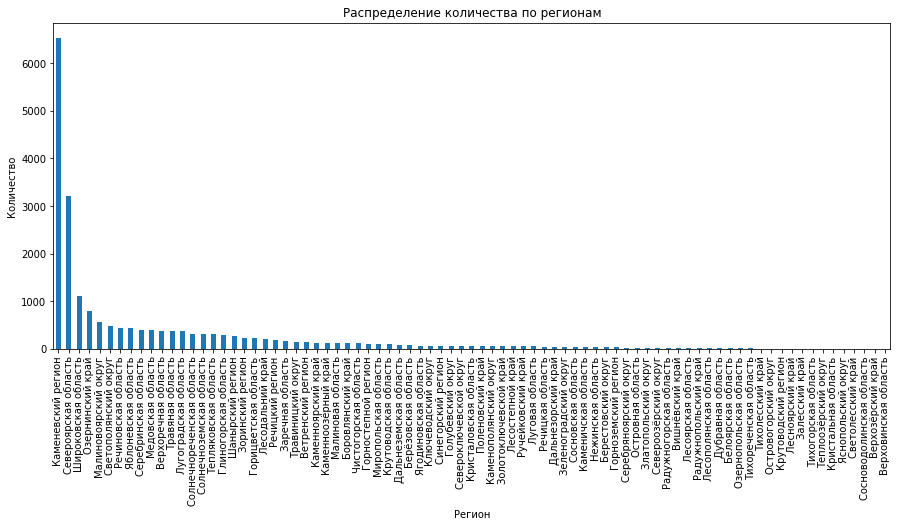

In [75]:
plt.figure(figsize=(15, 6))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
colich_region_name.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение количества по регионам'
)

# Настраиваем оформление графика
plt.xlabel('Регион')
plt.ylabel('Количество')

# Выводим график
plt.show()

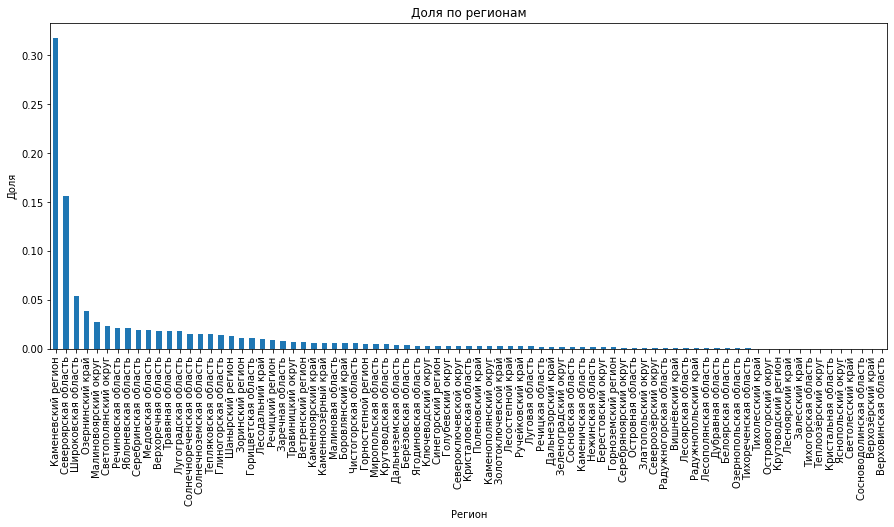

In [76]:
plt.figure(figsize=(15, 6))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
dolya_region_name.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Доля по регионам'
)

# Настраиваем оформление графика
plt.xlabel('Регион')
plt.ylabel('Доля')

# Выводим график
plt.show()

In [77]:
colich_service_name=final_df['service_name'].value_counts()
print(f'Распределение количества по билетному оператору:\n{colich_service_name}')
dolya_service_name=final_df['service_name'].value_counts()/len(final_df)
print(f'Доля по билетному оператору:\n{dolya_service_name}')

Распределение количества по билетному оператору:
Билеты без проблем        4523
Лови билет!               2834
Мой билет                 2797
Билеты в руки             2304
Облачко                   2125
Лучшие билеты             1314
Весь в билетах            1220
Прачечная                  566
Яблоко                     392
Край билетов               391
Тебе билет!                370
Дом культуры               290
Городской дом культуры     235
За билетом!                216
Мир касс                   182
Быстробилет                174
Show_ticket                140
Выступления.ру             128
Восьмёрка                   59
Радио ticket                57
Crazy ticket!               54
Шоу начинается!             45
Телебилет                   35
Росбилет                    30
Быстрый кассир              16
Кино билет                  14
КарандашРУ                  13
Цвет и билет                13
Реестр                       9
Билет по телефону            8
Вперёд!              

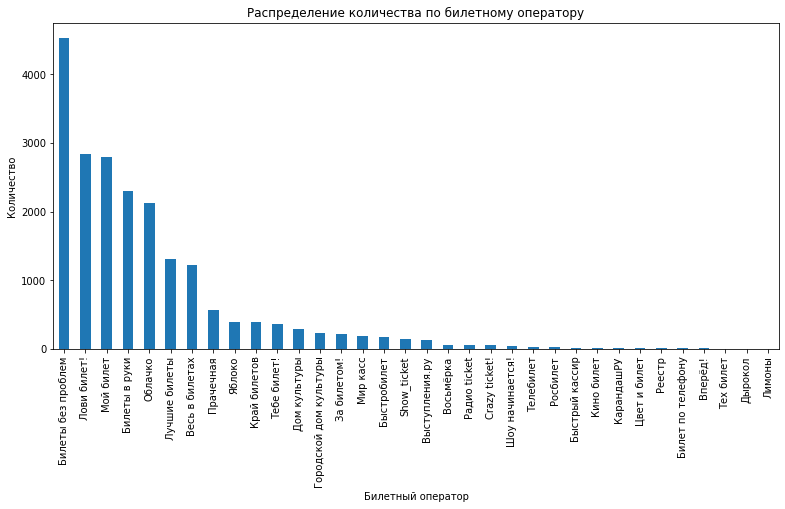

In [78]:
plt.figure(figsize=(13, 6))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
colich_service_name.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение количества по билетному оператору'
)

# Настраиваем оформление графика
plt.xlabel('Билетный оператор')
plt.ylabel('Количество')

# Выводим график
plt.show()

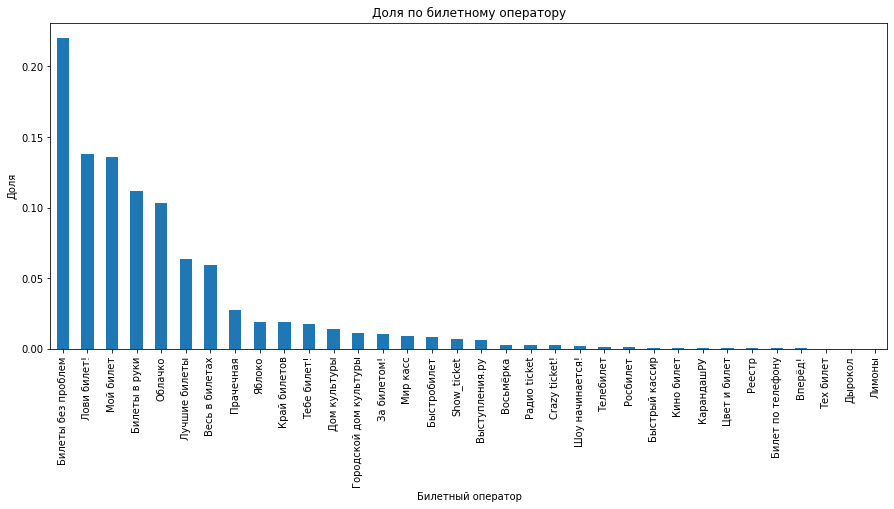

In [79]:
plt.figure(figsize=(15, 6))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
dolya_service_name.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Доля по билетному оператору'
)

# Настраиваем оформление графика
plt.xlabel('Билетный оператор')
plt.ylabel('Доля')

# Выводим график
plt.show()

*По типам мероприятий*

На концерт, другое и театр больше всего первых покупок. 

Концерт 44.4%, Театр 19.6%. 

Остальные Стендап, Спорт, Выставки и Елки вместе взятые - это около 10% от общего числа

*По типам устройств*

Мобильные заказы явный лидер - 83 %, ПК - 17 %

*По регионам*

Выделяются Каменевский регион 33% и Североярская область 17% остальные 6% и ниже

*По билетному оператору*

Пятерка лидеров
1) Билеты без проблем        23%
2) Мой билет                 14%
3) Лови билет!               13%
4) Билеты в руки             11%
5) Облачко                   10%

У других меньше 5%


---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [80]:
final_df_2=final_df[final_df['is_two']>0].copy()

In [81]:
len(final_df)

20567

In [82]:
colich_event_type_main=final_df_2['event_type_main'].value_counts()
print(f'Распределение количества по типам мероприятий:\n{colich_event_type_main}')
dolya_event_type_main=final_df_2['event_type_main'].value_counts()/final_df['event_type_main'].value_counts()
print(f'Доля по типам мероприятий:\n{dolya_event_type_main.sort_values(ascending=False)}')

Распределение количества по типам мероприятий:
концерты    4845
театр       2712
другое      2556
спорт        594
стендап      548
выставки     261
ёлки         150
Name: event_type_main, dtype: int64
Доля по типам мероприятий:
ёлки        0.777202
выставки    0.624402
театр       0.619319
спорт       0.614907
концерты    0.550756
стендап     0.540967
другое      0.532389
Name: event_type_main, dtype: float64


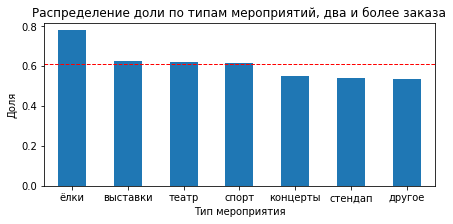

In [83]:
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
dolya_event_type_main.sort_values(ascending=False).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли по типам мероприятий, два и более заказа'
)

mean_churn_share = dolya_event_type_main.mean()

# Наносим на график линию с средним значением доли нелояльных клиентов
plt.axhline(mean_churn_share, # Данные, по которым строится линия
            color='red', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            label=f'средний рейтинг {round(mean_churn_share,4)}')

# Настраиваем оформление графика
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля')

# Выводим график
plt.show()

In [84]:
colich_device_type_canonical=final_df_2['device_type_canonical'].value_counts()
print(f'Распределение количества по типам устройств:\n{colich_device_type_canonical}')
dolya_device_type_canonical=final_df_2['device_type_canonical'].value_counts()/final_df['device_type_canonical'].value_counts()
print(f'Доля по типам устройств:\n{dolya_device_type_canonical.sort_values(ascending=False)}')

Распределение количества по типам устройств:
mobile     9614
desktop    2052
Name: device_type_canonical, dtype: int64
Доля по типам устройств:
desktop    0.589486
mobile     0.562683
Name: device_type_canonical, dtype: float64


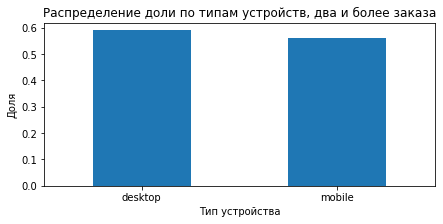

In [85]:
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
dolya_device_type_canonical.sort_values(ascending=False).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли по типам устройств, два и более заказа'
)

# Настраиваем оформление графика
plt.xlabel('Тип устройства')
plt.ylabel('Доля')

# Выводим график
plt.show()

In [86]:
colich_region_name=final_df_2['region_name'].value_counts()
print(f'Распределение количества по типам мероприятий:\n{colich_region_name.sort_values(ascending=False)[:10]}')
dolya_region_name=final_df_2['region_name'].value_counts()/final_df['region_name'].value_counts()
print(f'Доля по типам мероприятий:\n{dolya_region_name.sort_values(ascending=False)[:10]}')

Распределение количества по типам мероприятий:
Каменевский регион      3704
Североярская область    1750
Широковская область      636
Озернинский край         468
Малиновоярский округ     318
Светополянский округ     310
Речиновская область      268
Яблоневская область      254
Серебринская область     245
Медовская область        243
Name: region_name, dtype: int64
Доля по типам мероприятий:
Верхозёрский край         1.000000
Дубравная область         0.769231
Озернопольская область    0.750000
Берестовский округ        0.677419
Горностепной регион       0.666667
Лесноярский край          0.666667
Речицкая область          0.659574
Каменноозёрный край       0.656000
Вишнёвский край           0.650000
Кристаловская область     0.649123
Name: region_name, dtype: float64


In [87]:
df_region = pd.DataFrame({
'count': colich_region_name,
'dolya': dolya_region_name
})
df_top_region = df_region.sort_values('count', ascending=False).head(10)
print(df_top_region)

                       count     dolya
Каменевский регион    3704.0  0.567576
Североярская область  1750.0  0.545852
Широковская область    636.0  0.572457
Озернинский край       468.0  0.583541
Малиновоярский округ   318.0  0.560847
Светополянский округ   310.0  0.645833
Речиновская область    268.0  0.606335
Яблоневская область    254.0  0.590698
Серебринская область   245.0  0.610973
Медовская область      243.0  0.607500


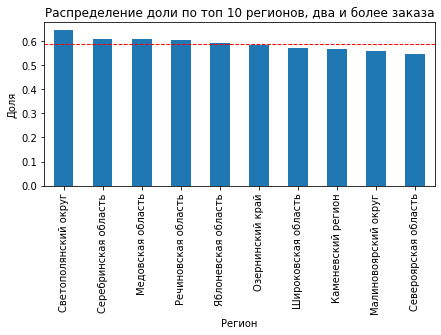

In [88]:
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
df_top_region['dolya'].sort_values(ascending=False).head(10).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли по топ 10 регионов, два и более заказа'
)
mean_churn_share = df_top_region['dolya'].mean()

# Наносим на график линию с средним значением 
plt.axhline(mean_churn_share, # Данные, по которым строится линия
            color='red', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            )

# Настраиваем оформление графика
plt.xlabel('Регион')
plt.ylabel('Доля')

# Выводим график
plt.show()

In [89]:
colich_service_name=final_df['service_name'].value_counts()
print(f'Распределение количества по билетному оператору:\n{colich_service_name.sort_values(ascending=False)[:10]}')
dolya_service_name=final_df_2['service_name'].value_counts()/final_df['service_name'].value_counts()
print(f'Доля по билетному оператору:\n{dolya_service_name.sort_values(ascending=False)}')

Распределение количества по билетному оператору:
Билеты без проблем    4523
Лови билет!           2834
Мой билет             2797
Билеты в руки         2304
Облачко               2125
Лучшие билеты         1314
Весь в билетах        1220
Прачечная              566
Яблоко                 392
Край билетов           391
Name: service_name, dtype: int64
Доля по билетному оператору:
Дырокол                   1.000000
Билет по телефону         0.875000
Crazy ticket!             0.740741
Кино билет                0.714286
Шоу начинается!           0.688889
Выступления.ру            0.679688
Тебе билет!               0.632432
Радио ticket              0.631579
Лучшие билеты             0.621005
Городской дом культуры    0.608511
Яблоко                    0.604592
Быстробилет               0.603448
За билетом!               0.592593
Лови билет!               0.587862
Прачечная                 0.586572
Край билетов              0.575448
Весь в билетах            0.573770
Облачко                 

In [90]:
df_service_name = pd.DataFrame({
'count': colich_service_name,
'dolya': dolya_service_name
})
df_top_service_name = df_service_name.sort_values('count', ascending=False).head(10)
print(df_top_service_name )

                    count     dolya
Билеты без проблем   4523  0.532832
Лови билет!          2834  0.587862
Мой билет            2797  0.552735
Билеты в руки        2304  0.560330
Облачко              2125  0.564706
Лучшие билеты        1314  0.621005
Весь в билетах       1220  0.573770
Прачечная             566  0.586572
Яблоко                392  0.604592
Край билетов          391  0.575448


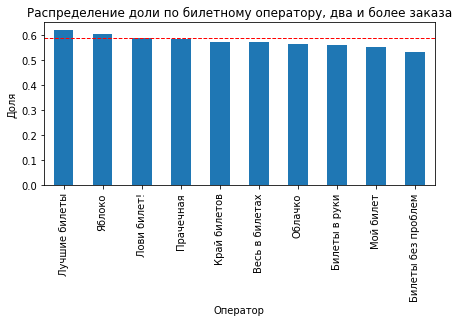

In [91]:
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
df_top_service_name['dolya'].sort_values(ascending=False).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли по билетному оператору, два и более заказа'
)
mean_churn_share = df_top_region['dolya'].mean()

# Наносим на график линию с средним значением 
plt.axhline(mean_churn_share, # Данные, по которым строится линия
            color='red', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            )

# Настраиваем оформление графика
plt.xlabel('Оператор')
plt.ylabel('Доля')

# Выводим график
plt.show()

*По типам мероприятий*

Выше среднего показателя выставки 63% и театр 62%

*По типам устройств*

ПК - 62% против мобильных - 59%

*По регионам*

Особенно выделяются Широковская область 63%, Шанырский регион 65%, Светополянский округ 64%

*По билетному оператору*

Край билетов 63%, Дом культуры 63%


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

**Не подтверждается**

спорт 53% вернувшихся(ниже среднего), концерты 60% вернувшихся(средний показатель)


Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

**Не подтверждается**

Топовые по посещению регионы Каменевский регион 60%, Североярская область 62%, в то время как в других менее активных есть показатели до 65% 

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


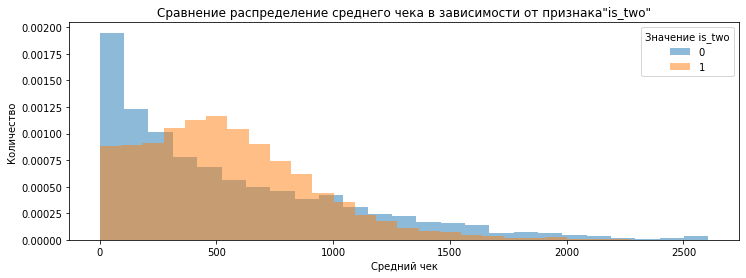

In [92]:
plt.figure(figsize=(12, 4))

# Строим гистограммы для каждого значения churn
for i in final_df['is_two'].unique():
    # Фильтруем данные по значению столбца churn
    final_df.loc[final_df['is_two'] == i, 'avg_revenue'].plot(
        kind='hist',
        bins=25,
        alpha=0.5,
        label=f'{i}',
        legend=True,
        density=True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение распределение среднего чека в зависимости от признака"is_two"')
plt.xlabel('Средний чек')
plt.ylabel('Количество')
plt.legend(title='Значение is_two')
plt.show() 

Для тех кто вернулся средний чек выше в области от 300 до 900 руб, в остльных областях выше у тех, кто совершил только один заказ.

Больше всего пользователей совершивших один заказ в области 0-200, далее постепенное снижение.
Больше всего пользователей совершивших повторный заказ в области 300-500.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


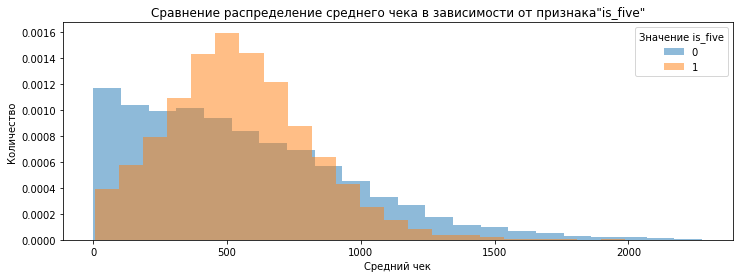

In [93]:
new_df_five = final_df.loc[(final_df['is_two'] > 0)]

plt.figure(figsize=(12, 4))

# Строим гистограммы для каждого значения churn
for i in new_df_five['is_five'].unique():
    # Фильтруем данные по значению столбца churn
    new_df_five.loc[new_df_five['is_five'] == i, 'avg_revenue'].plot(
        kind='hist',
        bins=22,
        alpha=0.5,
        label=f'{i}',
        legend=True,
        density=True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение распределение среднего чека в зависимости от признака"is_five"')
plt.xlabel('Средний чек')
plt.ylabel('Количество')
plt.legend(title='Значение is_five')
plt.show()

In [94]:
#new_df_five['avg_revenue'].hist(figsize=(5, 5), bins=25)

Для тех кто вернулся более 5 раз средний чек также выше в области от 300 до 800 руб, в остльных областях выше у тех, кто совершил 2-4 заказа.

Больше всего пользователей совершивших 2-4 заказа в области 0-200.
Больше всего пользователей совершивших повторный заказ более 5 раз в области 300-700.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [95]:
new_df_avg_2 = final_df.loc[(final_df['avg_tickets'] >= 1) & (final_df['avg_tickets'] < 2)]
len(new_df_avg_2)

2228

In [96]:
new_df_avg_2['is_two'].mean()

0.43357271095152605

In [97]:
new_df_avg_3 = final_df.loc[(final_df['avg_tickets'] >= 2) & (final_df['avg_tickets'] < 3)]
len(new_df_avg_3)

8679

In [98]:
new_df_avg_3['is_two'].mean()

0.6921304297730153

In [99]:
new_df_avg_5 = final_df.loc[(final_df['avg_tickets'] >= 3) & (final_df['avg_tickets'] < 5)]
len(new_df_avg_5)

9015

In [100]:
new_df_avg_5['is_two'].mean()

0.5108153078202995

In [101]:
new_df_avg_b5 = final_df.loc[(final_df['avg_tickets'] >=5)]
len(new_df_avg_b5)

645

In [102]:
new_df_avg_b5['is_two'].mean()

0.13643410852713178

Пользователи по сегментам распределены не равномерно, больше всего пользователей от 2 до 5 билетов в заказе.

Очень большой показатель повторных покупок у пользователей с билетами >=2 и <3 билетов в заказе.

Очень низкий показатель 5 и более.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [103]:
final = final_df.copy()

final['day_week'] = final['first_order'].dt.weekday

In [104]:
colich_day_week=final['day_week'].value_counts()
print(f'Распределение количества по билетному оператору:\n{colich_day_week}')

Распределение количества по билетному оператору:
4    3135
5    3091
1    3007
3    2997
2    2936
0    2786
6    2615
Name: day_week, dtype: int64


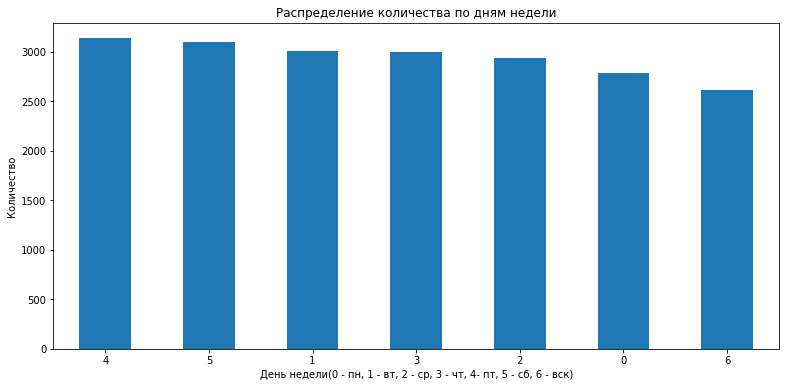

In [105]:
plt.figure(figsize=(13, 6))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
colich_day_week.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение количества по дням недели'
)

# Настраиваем оформление графика
plt.xlabel('День недели(0 - пн, 1 - вт, 2 - ср, 3 - чт, 4- пт, 5 - сб, 6 - вск)')
plt.ylabel('Количество')

# Выводим график
plt.show()

In [106]:
final.groupby('day_week')['is_two'].mean()

day_week
0    0.582556
1    0.566678
2    0.579360
3    0.551885
4    0.557895
5    0.577807
6    0.554111
Name: is_two, dtype: float64

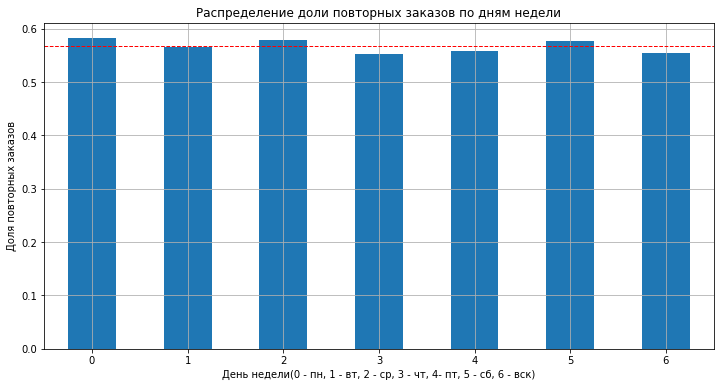

In [107]:
plt.figure(figsize=(12, 6))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
final.groupby('day_week')['is_two'].mean().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли повторных заказов по дням недели')

plt.axhline(final.groupby('day_week')['is_two'].mean().mean(), color='red',
                linestyle='--', linewidth=1,)

# Настраиваем оформление графика
plt.xlabel('День недели(0 - пн, 1 - вт, 2 - ср, 3 - чт, 4- пт, 5 - сб, 6 - вск)')
plt.ylabel('Доля повторных заказов')
plt.grid()
# Выводим график
plt.show()

день недели влияет на вероятность возврата клиента, но не сильно. Выше среднего показатели у пн, ср, сб - 60% и больше.

Сильно ниже остальных показатель вск - 57%

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [108]:
new_df_1 = final.loc[(final_df['is_two'] < 1)]

In [109]:
new_df_2 = final.loc[(final_df['is_two'] > 0) & (final_df['is_five'] < 1)]

In [110]:
new_df_5 = final.loc[(final_df['is_five'] > 0)]

In [111]:
new_df_2['avg_days'].mean()

23.05747

In [112]:
new_df_5['avg_days'].mean()

13.763423

Для тех кто совершил 5 и более заказов среднее время между заказами менее 2 недель. Для тех кто сделал 2-4 заказа около 3 недель.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [113]:
print(final.head())

           user_id         first_order          last_order  \
0  0002849b70a3ce2 2024-08-20 16:08:03 2024-08-20 16:08:03   
1  0005ca5e93f2cf4 2024-07-23 18:36:24 2024-10-06 13:56:02   
2  000898990054619 2024-07-13 19:40:48 2024-10-23 15:12:00   
3  00096d1f542ab2b 2024-08-15 16:48:48 2024-08-15 16:48:48   
4  000a55a418c128c 2024-09-29 19:39:12 2024-10-15 10:29:04   

  device_type_canonical           region_name   service_name event_type_main  \
0                mobile    Каменевский регион   Край билетов           театр   
1                mobile    Каменевский регион    За билетом!          другое   
2                mobile  Лугоградская область        Облачко        концерты   
3               desktop    Каменевский регион   Край билетов           театр   
4                mobile      Поленовский край  Лучшие билеты           театр   

   order_count  avg_revenue  avg_tickets  avg_days  is_two  is_five  day_week  
0            1  1521.939941     4.000000       NaN       0        

In [114]:
y=0
def create_is_y(x):
    if x<y:
        return 1
    return 0

y=2
final['is_one'] = final['order_count'].apply(create_is_y)

In [115]:
print(final.head())

           user_id         first_order          last_order  \
0  0002849b70a3ce2 2024-08-20 16:08:03 2024-08-20 16:08:03   
1  0005ca5e93f2cf4 2024-07-23 18:36:24 2024-10-06 13:56:02   
2  000898990054619 2024-07-13 19:40:48 2024-10-23 15:12:00   
3  00096d1f542ab2b 2024-08-15 16:48:48 2024-08-15 16:48:48   
4  000a55a418c128c 2024-09-29 19:39:12 2024-10-15 10:29:04   

  device_type_canonical           region_name   service_name event_type_main  \
0                mobile    Каменевский регион   Край билетов           театр   
1                mobile    Каменевский регион    За билетом!          другое   
2                mobile  Лугоградская область        Облачко        концерты   
3               desktop    Каменевский регион   Край билетов           театр   
4                mobile      Поленовский край  Лучшие билеты           театр   

   order_count  avg_revenue  avg_tickets  avg_days  is_two  is_five  day_week  \
0            1  1521.939941     4.000000       NaN       0       

In [116]:
correlation_matrix = final[['device_type_canonical', 'region_name', 'service_name', 'event_type_main', 'order_count','avg_revenue','avg_tickets','avg_days','day_week','is_one','is_two','is_five']].phik_matrix()
print('Корреляционная матрица с коэффициентом phi_k для переменной order_count')
correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count','is_one','is_two','is_five']].sort_values(by='order_count', ascending=False)

interval columns not set, guessing: ['order_count', 'avg_revenue', 'avg_tickets', 'avg_days', 'day_week', 'is_one', 'is_two', 'is_five']
Корреляционная матрица с коэффициентом phi_k для переменной order_count


,order_count,is_one,is_two,is_five
is_five,0.991031,0.635095,0.635095,1.000000
is_one,0.672737,1.000000,1.000000,0.635095
is_two,0.672737,1.000000,1.000000,0.635095
avg_days,0.537285,0.125873,0.125873,0.451604
avg_tickets,0.401757,0.750983,0.750983,0.437691
avg_revenue,0.298161,0.323995,0.323995,0.336638
region_name,0.093263,0.078304,0.078304,0.095946
event_type_main,0.053398,0.073692,0.073692,0.058435
service_name,0.034190,0.070466,0.070466,0.048244
day_week,0.029106,0.015502,0.015502,0.015984


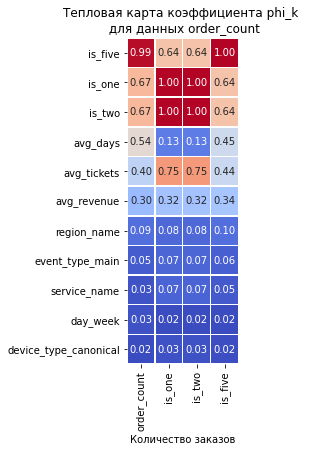

In [117]:
# Строим тепловую карту
plt.figure(figsize=(2, 6))

data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count','is_one','is_two','is_five']].sort_values(by='order_count', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных order_count')
plt.xlabel('Количество заказов')

# Выводим график
plt.show()

In [118]:
correlation_matrix = new_df_2[['device_type_canonical', 'region_name', 'service_name', 'event_type_main', 'order_count','avg_revenue','avg_tickets','avg_days','day_week']].phik_matrix()
print('Корреляционная матрица с коэффициентом phi_k для переменной rating')
correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count']].sort_values(by='order_count', ascending=False)

interval columns not set, guessing: ['order_count', 'avg_revenue', 'avg_tickets', 'avg_days', 'day_week']
Корреляционная матрица с коэффициентом phi_k для переменной rating


,order_count
avg_days,0.423345
avg_tickets,0.319281
avg_revenue,0.138960
region_name,0.051637
service_name,0.044634
device_type_canonical,0.000000
event_type_main,0.000000
day_week,0.000000


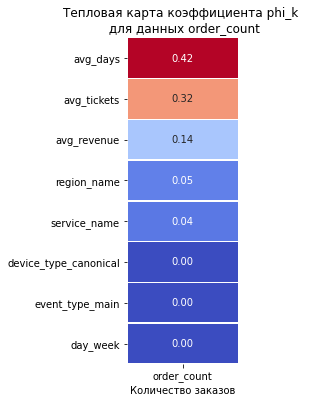

In [119]:
# Строим тепловую карту
plt.figure(figsize=(2, 6))

data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count']].sort_values(by='order_count', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных order_count')
plt.xlabel('Количество заказов')

# Выводим график
plt.show()

In [120]:
correlation_matrix = new_df_5[['device_type_canonical', 'region_name', 'service_name', 'event_type_main', 'order_count','avg_revenue','avg_tickets','avg_days','day_week']].phik_matrix()
print('Корреляционная матрица с коэффициентом phi_k для переменной rating')
correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count']].sort_values(by='order_count', ascending=False)

interval columns not set, guessing: ['order_count', 'avg_revenue', 'avg_tickets', 'avg_days', 'day_week']
Корреляционная матрица с коэффициентом phi_k для переменной rating


,order_count
avg_days,0.735216
avg_tickets,0.263769
avg_revenue,0.201522
region_name,0.129075
service_name,0.080501
device_type_canonical,0.039689
day_week,0.035974
event_type_main,0.000000


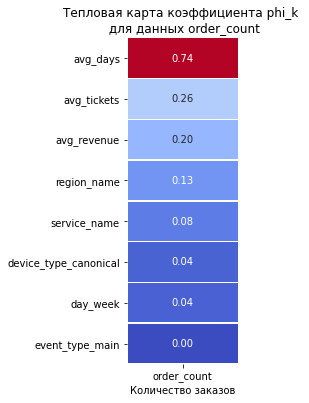

In [121]:
# Строим тепловую карту
plt.figure(figsize=(2, 6))

data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count']].sort_values(by='order_count', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных order_count')
plt.xlabel('Количество заказов')

# Выводим график
plt.show()

На то, совершил ли пользователь только один заказ сильно влияет среднее количество билетов в заказе(коэф кор 0,7) и средний чек(коэф кор 0,3).

На то, совершил ли пользователь 2-4 заказа сильно влияет среднее количество билетов в заказе(коэф кор 0,39) и количество дней между заказами(коэф кор 0,38).

На то, совершил ли пользователь 5 и более заказов сильно влияет количество дней между заказами(коэф кор 0,7).

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**ВЫВОД**

а) **Подготовка**

Выгружены данные из базы SQL, общий начальный объем составил 14 столбцов и 290611 строк.

Выручка приведена к единой валюте 'rub', пересчет произведен по отношению к курсу валют на дату совершения сделки.

Проверены статистические данные, произошла фильтрация по 99 процентилю из-за сильных выбросов влияющих на общую статистику в столбцах по количеству приобретенных билетов и по количеству билетов в заказе.
Эти данные составили 1% от общего числа строк.

Добавлены столбцы `is_two` — совершил ли пользователь 2 и более заказа;
и `is_five`— совершил ли пользователь 5 и более заказов.

Произошла группировка по пользователям (всего пользователей 21847) и проверка на аномальные значения статичтических данных.
В количестве заказов у некоторых пользователей обнаружено аномально большие значения. Принято решение отфильтровать по 95-му перцентилю.

Итоговый набор данных был сокращен на 5%, что составляет набор данных по 20 594 пользователям.

б) **Основные результаты анализа**

**Распределение пользователей:**

*По типам мероприятий*

На концерт и театр больше всего первых покупок.Концерт 44.4%, Театр 19.6%. 

*По типам устройств*

Мобильные заказы явный лидер - 83 %, ПК - 17 %

*По регионам*

Выделяются Каменевский регион 33% и Североярская область 17% остальные 6% и ниже

*По билетному оператору*

Пятерка лидеров
1) Билеты без проблем        23%
2) Мой билет                 14%
3) Лови билет!               13%
4) Билеты в руки             11%
5) Облачко                   10%

У других меньше 5%

**Доля возвратов пользователей по первому заказу:**

*По типам мероприятий*

Выше среднего показателя выставки 63% и театр 62%

*По типам устройств*

ПК - 62% против мобильных - 59%

*По регионам*

Особенно выделяются Широковская область 63%, Шанырский регион 65%, Светополянский округ 64%

*По билетному оператору*

Край билетов 63%, Дом культуры 63%

**Продуктовые гипотезы:**

Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

**Не подтверждается**

спорт 53% вернувшихся(ниже среднего), концерты 60% вернувшихся(средний показатель)

Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

**Не подтверждается**

Топовые по посещению регионы Каменевский регион 60%, Североярская область 62%, в то время как в других менее активных есть показатели до 65% 

**Влияние средней выручки на возврат клиента**

Для тех кто вернулся 5 и более раз средний чек выше в области от 300 до 800 руб чем у тех кто сделал 1 заказ или 2-4 заказа, для этих данных распределение от 0 постепенно убывает.

**Влияние среднего количества билетов на возврат клиента**

Пользователи по сегментам распределены не равномерно, больше всего пользователей от 2 до 5 билетов в заказе.

Очень большой показатель повторных покупок у пользователей с билетами >=2 и <3 билетов в заказе.

Очень низкий показатель 5 и более.

**Влияние дня недели на возврат клиента**

день недели влияет на вероятность возврата клиента, но не сильно. Выше среднего показатели у пн, ср, сб - 60% и больше.

Сильно ниже остальных показатель вск - 57%

**Влияние интервала между покупками на возврат клиента**

Для тех кто совершил 5 и более заказов среднее время между заказами менее 2 недель. Для тех кто сделал 2-4 заказа около 3 недель.

**Анализ количества покупок и характеристики первого заказа**
На то, совершил ли пользователь только один заказ сильно влияет среднее количество билетов в заказе(коэф кор 0,7) и средний чек(коэф кор 0,3).

На то, совершил ли пользователь 2-4 заказа сильно влияет среднее количество билетов в заказе(коэф кор 0,39) и количество дней между заказами(коэф кор 0,38).

На то, совершил ли пользователь 5 и более заказов сильно влияет количество дней между заказами(коэф кор 0,7).

**РЕКОМЕНДАЦИИ**

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Необходимо обратить внимание на пользователей, которые делают первый заказ на концерты, с мобильных телефонов и из регионов с самым большим числом посетителей мероприятий - число покупателей выше чем у остальных категорий, но доля возвратов ниже.

Также необходимо пересмотреть всех топовых билетных операторов, у них число возвратных покупателей ниже среднего.

Средняя выручка для тех кто вернулся выше в диапазоне 300-800 руб.

Очень большой показатель повторных покупок у пользователей со среднем количеством билетов >=2 и <3 (видимо хорошие маркетинговые стратегии для пар)
с 3 до 5 меньше, стоит сделать упор на семейные мероприятия

По дням недели больше всего покупают в пятницу, но показатель возвратов ниже среднего.

Чем чаще покупают, тем меньше времени проходит между заказами.
На то совершил ли пользователь только один заказ сильно влияет количество билетов в заказе.

**КОРОТКО**

Слабые места по возрату - первый заказ на концерты, с мобильных телефонов, из регионов с самым большим числом посетителей мероприятий, топовые билетные операторы, покупки 3-5 билетов, покупки в пятницу.

Использование сильных сторон - Мероприятия для пар, средний чек 300-800 руб.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**